In [9]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import cartopy.crs as ccrs
import cartopy
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.cluster import KMeans
import STDBSCAN

In [10]:
ds_solar = xr.open_dataset('../data/Solar_forcing_1st_mill.nc')
ds_volc = xr.open_dataset('../data/Volc_Forc_AOD_1st_mill.nc')
ds_temp_r1 = xr.open_dataset('../data/T2m_R1_ym_1stMill.nc')

In [11]:
temp = ds_temp_r1['T2m'].values.copy()
X = temp.reshape(999, -1).transpose()
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

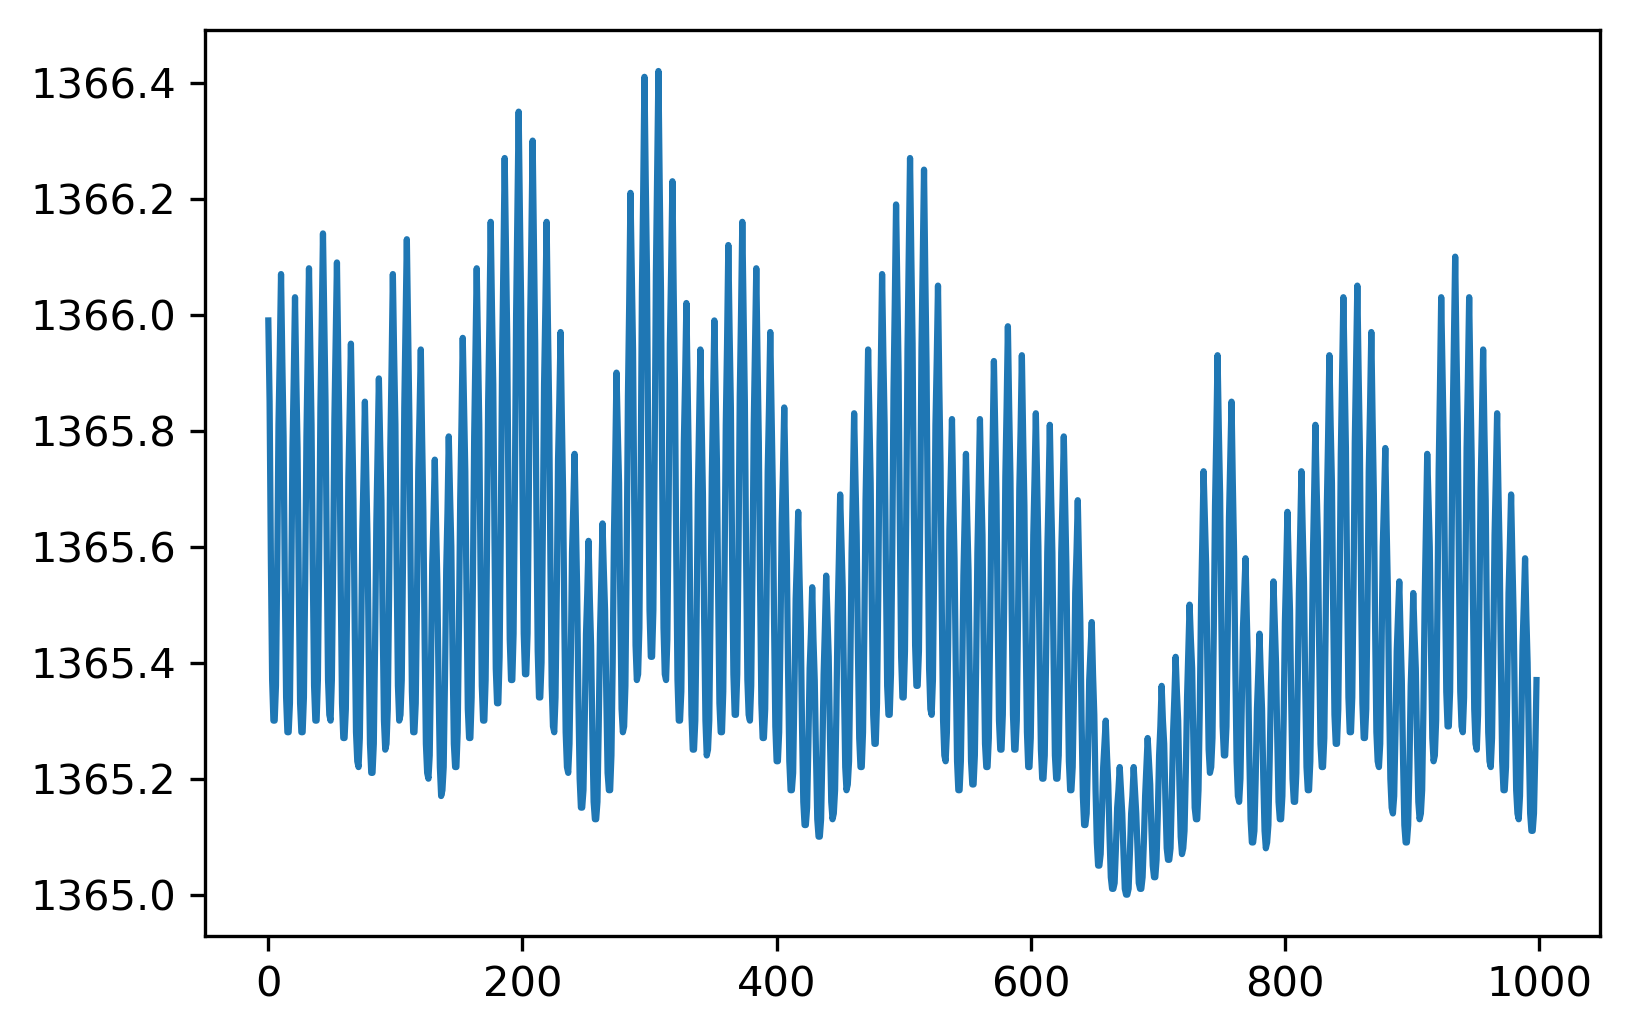

In [12]:
fig, ax = plt.subplots(1, 1, dpi=300)
ax.plot(ds_solar.TSI.values.flatten())

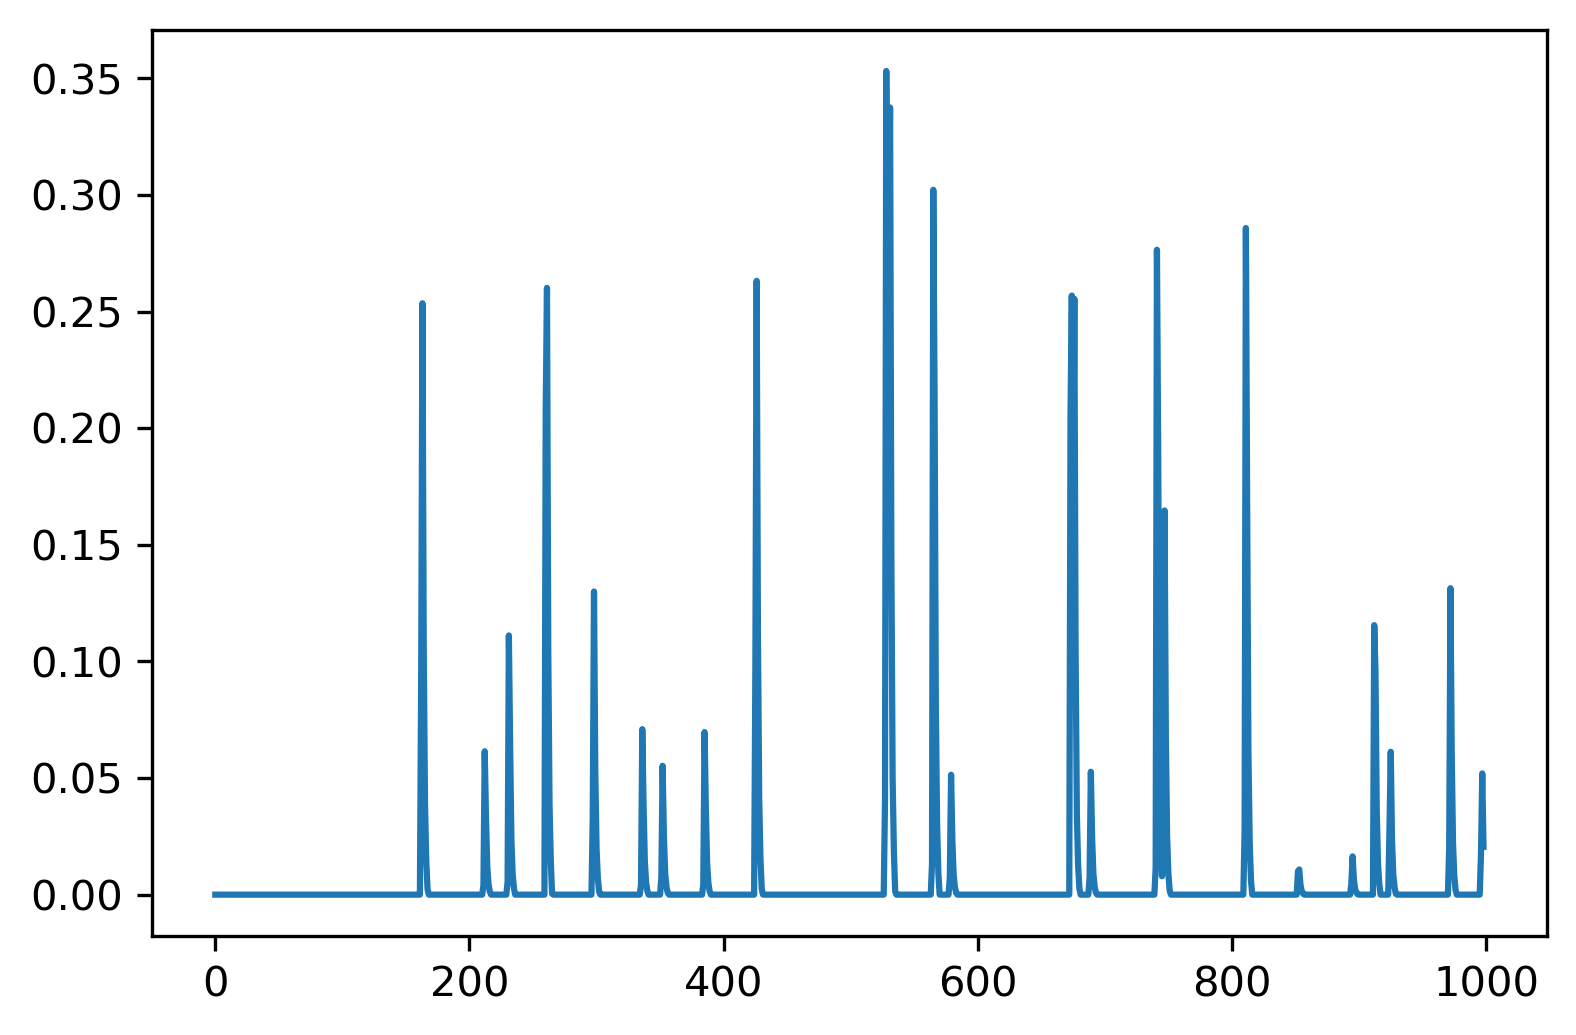

In [13]:
fig, ax = plt.subplots(1, 1, dpi=300)
ax.plot(ds_volc.AOD.values.flatten())

In [14]:
def smooth_butter(data):
    # Butterworth filter settings
    cutoff = 1   # Hz
    order = 8
    [b, a] = signal.butter(order, 0.125)   # The second parameter is a normed value in [0;1] where 1 is the Nyquist frequency, i.e. half of the sampling rate. In the case of 25 FPS, this means that 1 = 12.5 Hz and hence 0.08 = 1 Hz

    # axis = 0 means that the filter is applied on each column
    data = signal.filtfilt(b, a, data, method='gust')

    return data

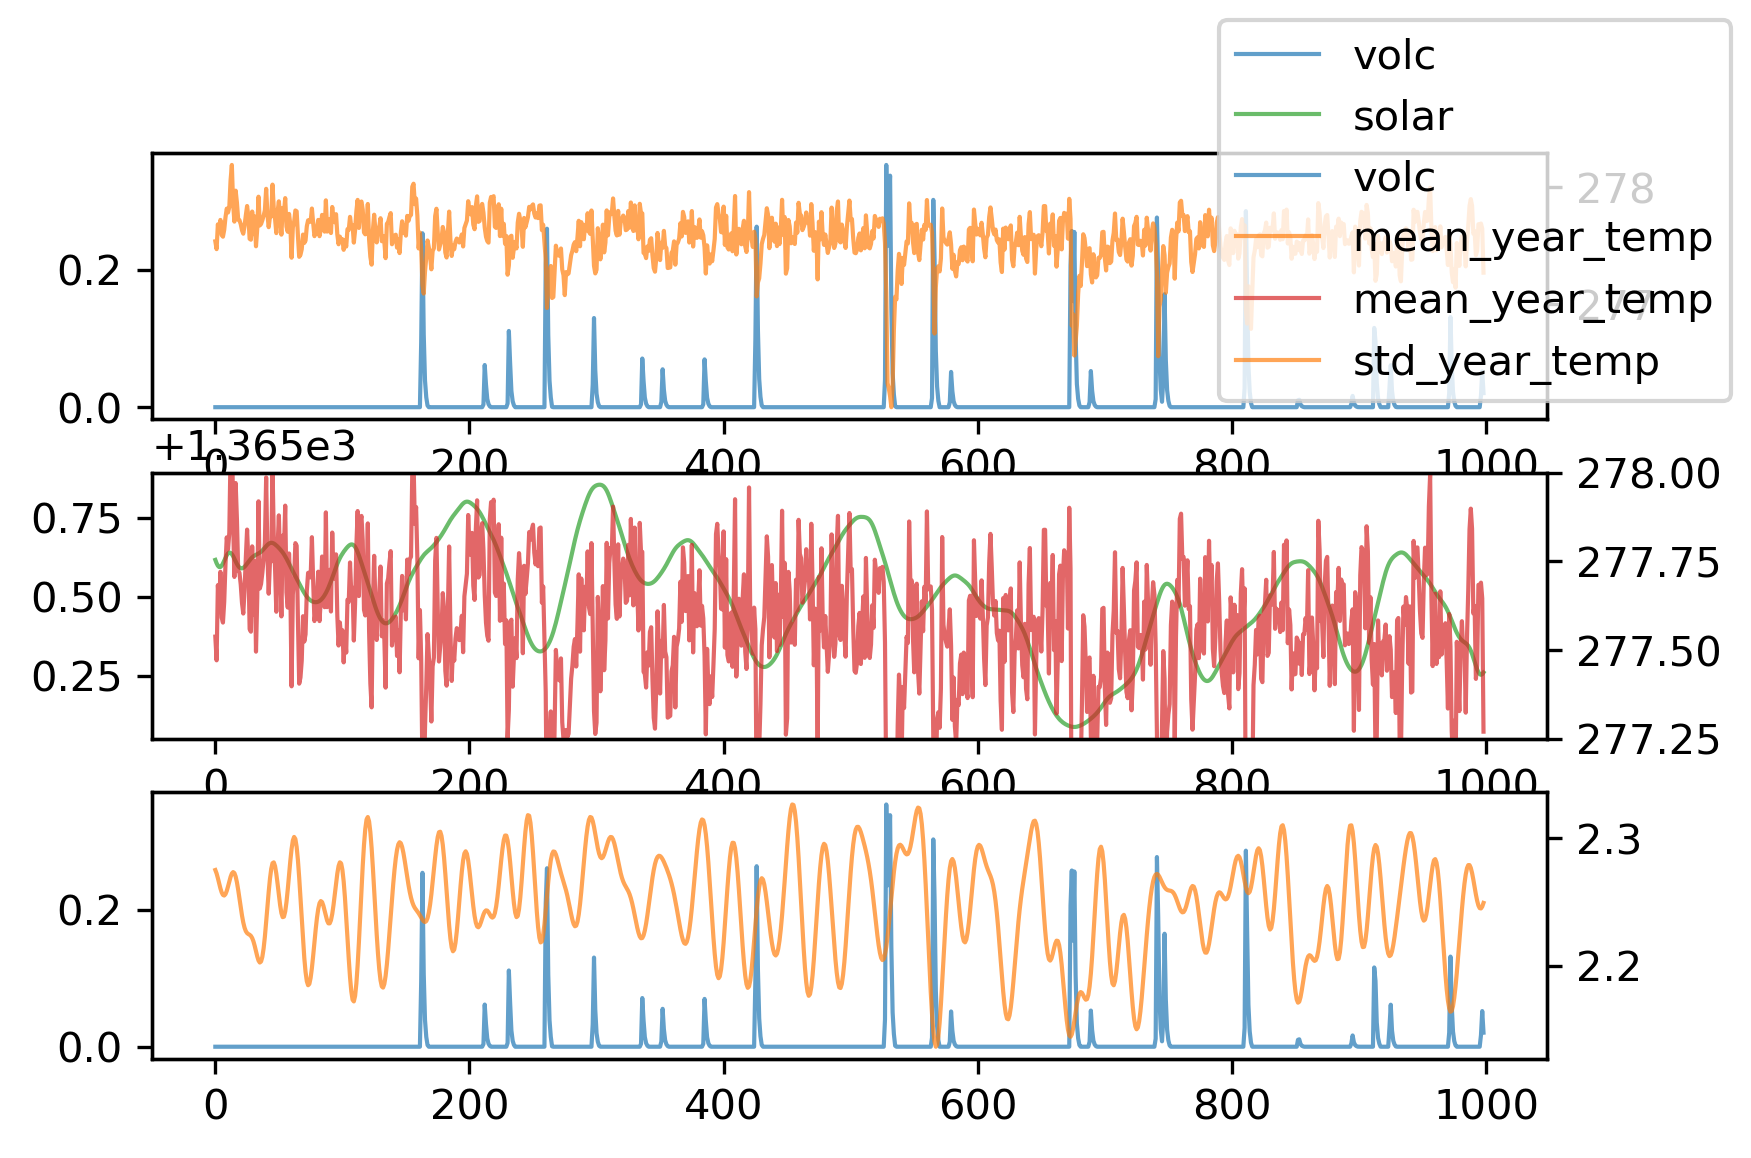

In [15]:
mean_year_temp = np.mean(np.mean(ds_temp_r1.T2m.values, axis=1), axis=1)
std_year_temp = smooth_butter(np.std(np.std(ds_temp_r1.T2m.values, axis=1), axis=1))
#mean_year_temp = smooth_butter(mean_year_temp)

aod = ds_volc.AOD.values.flatten()

solar = ds_solar.TSI.values.flatten()
solar = smooth_butter(solar)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=300)

ax1.plot(aod, label='volc', linewidth=1, alpha=0.7)
ax1_twin = ax1.twinx()
ax1_twin.plot(mean_year_temp, color='C1', label='mean_year_temp', linewidth=1, alpha=0.7)

ax2.plot(solar, label='solar', color='C2', linewidth=1, alpha=0.7)
ax2_twin = ax2.twinx()
ax2_twin.plot(mean_year_temp, color='C3', label='mean_year_temp', linewidth=1, alpha=0.7)
ax2_twin.set_ylim([277.25, 278])

ax3.plot(aod, label='volc', linewidth=1, alpha=0.7)
ax3_twin = ax3.twinx()
ax3_twin.plot(std_year_temp, color='C1', label='std_year_temp', linewidth=1, alpha=0.7)

fig.legend()

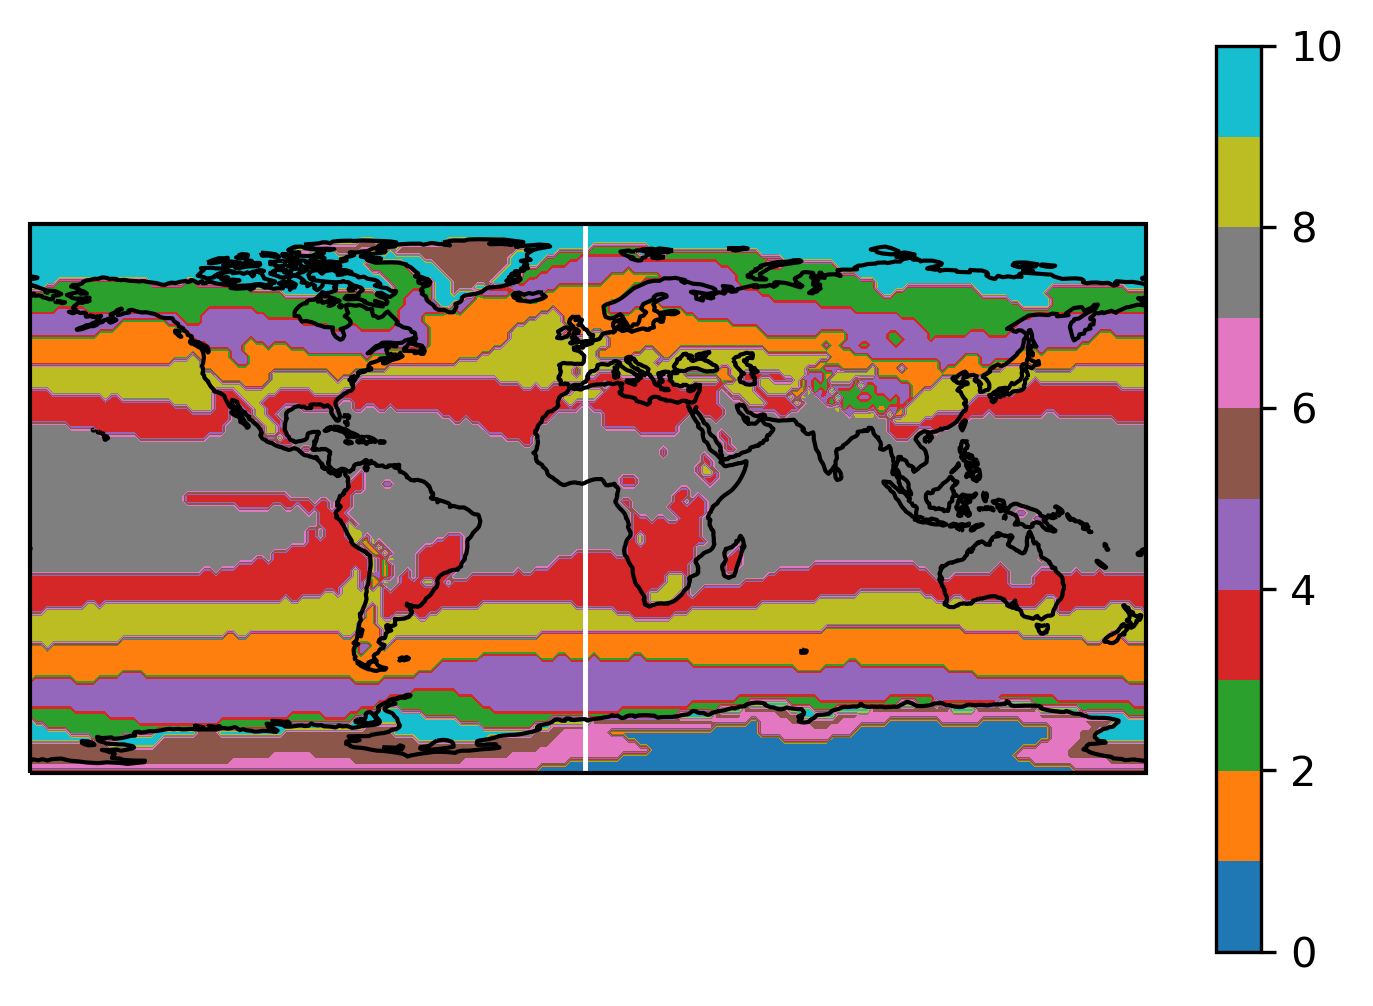

In [69]:
clusters = kmeans.labels_.reshape(96, 192)
lats = ds_temp_r1.variables['lat'][:]
lons = ds_temp_r1.variables['lon'][:]

fig, ax = plt.subplots(1, 1, dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lons, lats, clusters+0.5, 10, transform=ccrs.PlateCarree(), cmap=cm.tab10)

ax.coastlines()
fig.colorbar(cs)

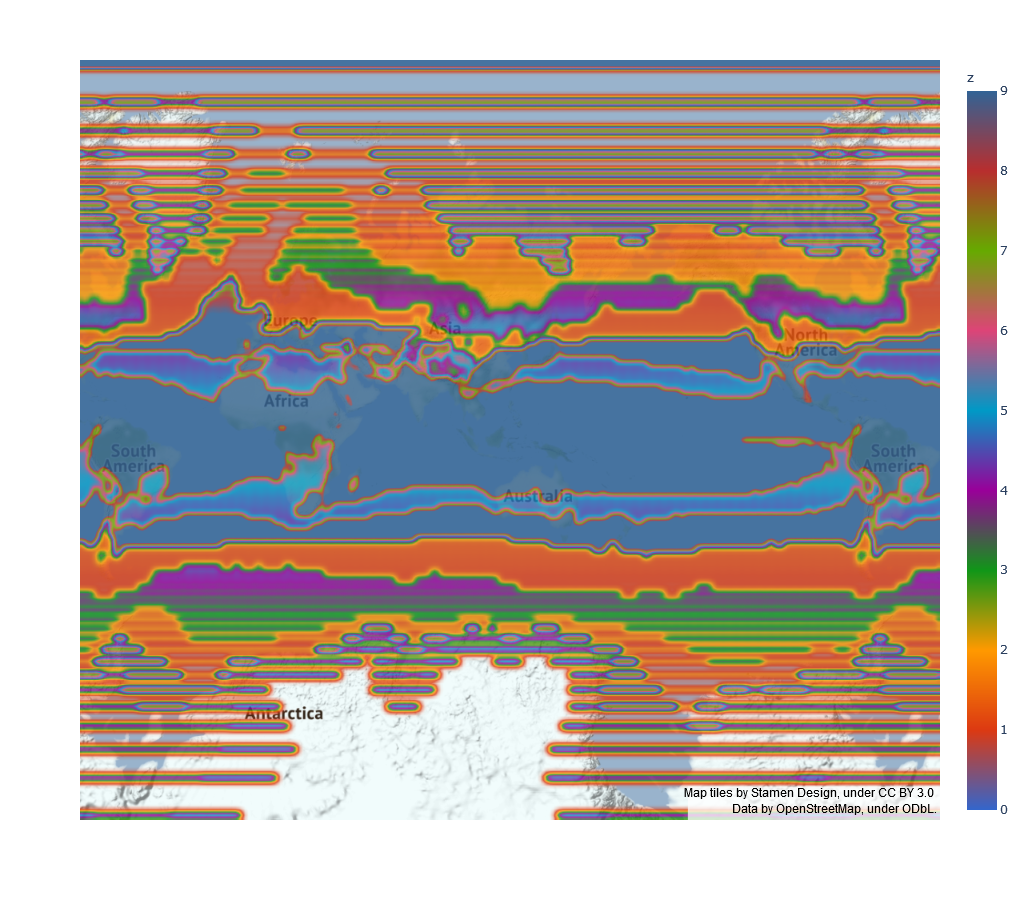

In [66]:
import pandas as pd
import plotly.express as px
lons_mat, lats_mat = np.meshgrid(lons, lats)
fig = px.density_mapbox(lat=lats_mat.flatten(), lon=lons_mat.flatten(), z=clusters.flatten(), radius=10, color_continuous_scale=px.colors.qualitative.G10,
                        center=dict(lat=0, lon=180), zoom=0, opacity=0.8,
                        mapbox_style="stamen-terrain")
fig.show()

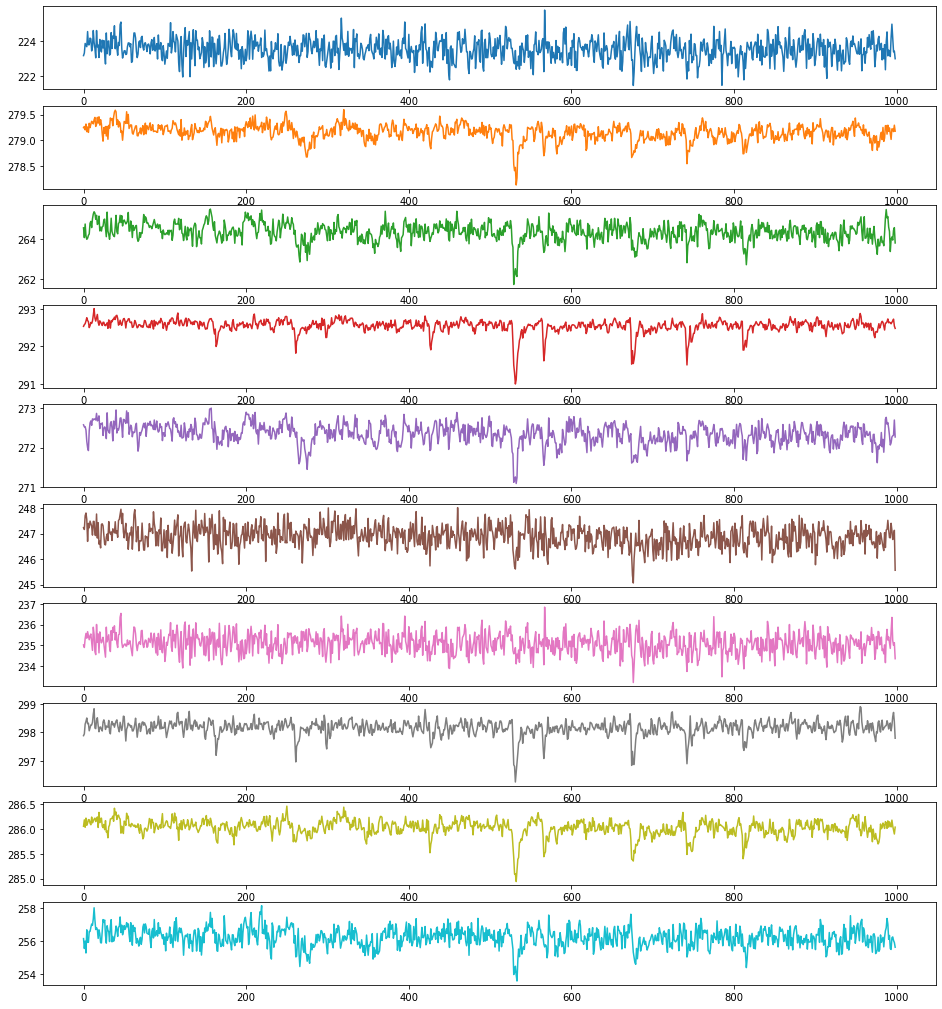

In [76]:
min_temp = np.min(mean_temp_clusters)
max_temp = np.max(mean_temp_clusters)

mean_temp_clusters = []
for c in np.unique(clusters):
    temps_cluster = ds_temp_r1['T2m'].values[:, clusters == c]
    temps_cluster = np.mean(temps_cluster, axis=1)
    mean_temp_clusters.append(temps_cluster)

fig, axes = plt.subplots(10, 1, figsize=(16, 18))
for i, ax in enumerate(axes.flatten()):
    ax.plot(mean_temp_clusters[i], color=cm.tab10((i+0.5)/10))
    #ax.set_ylim([min_temp, max_temp])